# Vanilla sound localization problem with a single delay layer (non-spiking)


Here, I showcase the solution to the sound localization problem using only differentiable delays. For this project, this is the fruit of the work done on differentiable delays. 
I truly grateful for everyone that I interacted with in this project. For me, it was a nice experience and I hope we can do similar projectes to tackle different projects in the future.

In [1]:
#@title Main docstring
"""Solving the sound localization problem with only differentiable delays (non-spiking)

Functions:
    input_signal: outputs poisson generated spike trains for a given input IPD
    get_batch: generate a fixed size patch of input-targets from the input-signal function
    snn_sl: defines the synaptic integration function
    analyse: a visualization function for the results of the training

Classes:
    Delaylayer: defines the delaylayer object
    Delayupdate: defines the object responisble for the application of surrogate delay updates
"""

'Solving the sound localization problem with only differentiable delays (non-spiking)\n\nFunctions:\n    input_signal: outputs poisson generated spike trains for a given input IPD\n    get_batch: generate a fixed size patch of input-targets from the input-signal function\n    snn_sl: defines the synaptic integration function\n    analyse: a visualization function for the results of the training\n\nClasses:\n    Delaylayer: defines the delaylayer object\n    Delayupdate: defines the object responisble for the application of surrogate delay updates\n'

## Imports

In [2]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

dtype = torch.float
torch.set_printoptions(precision=8, sci_mode=False, linewidth=200)
np.set_printoptions(precision=10, suppress=True)
np.random.seed(0)
torch.manual_seed(0)

## Definitions

In [3]:
#@title Relevant definitions
# Not using Brian so we just use these constants to make equations look nicer below
SECOND = 1
MS = 1e-3
HZ = 1
# Stimulus and simulation parameters
DT = 1 * MS            # Large time step to make simulations run faster for tutorial
ENVELOPE_POWER = 10   # Higher values make sharper envelopes, easier
RATE_MAX = 600 * HZ   # Maximum Poisson firing rate
F = 20 * HZ            # Stimulus frequency
DURATION = 50 * MS  # Stimulus duration
DURATION_STEPS = int(np.round(DURATION / DT)) # The length of the stimulus
ANG_STEP = 5 # Minimum angle difference between the IPD classes
NUMBER_CLASSES = int(180/ANG_STEP) # Number of IPD classes
# Training parameters
NB_EPOCHS = 20000  
BATCH_SIZE = 200
device = device = torch.device("cpu")
"""Delay paramters and functions"""
MAX_DELAY = 20  # Assumed to be in ms
NUMBER_INPUTS = 2 # Number of input spikes trains corresponding to the two ears
EFFECTIVE_DURATION = MAX_DELAY * 3 + int(np.round(DURATION / DT))
TAU, TAU_DECAY, TAU_MINI, TAU_DECAY_FLAG = 40, 0.005, 5, True  # Time constant decay settings
ROUND_DECIMALS = 4  # For the stability of the delay layer
FIX_FIRST_INPUT = True  # Fix the first input in delay learning
SHOW_IMAGE = True  # Visualization of the whole raster plot or target spikes
SYNAPSE_TYPE = 1  # 0 for multiplicaitve, 1 for subtractive
LR_DELAY = 2  # Learning rate for the differentiable delays

## Input-target generator

In [4]:
#@title Input target generators
def input_signal(ipd_choice=0):
    """Generates input-target pairs

    Parameters:
        ipd_choice(int): input ipd in degrees

    Returns:
        spikes_out(numpy.ndarray, (NUMBER_CLASSES, NUMBER_INPUTS, EFFECTIVE_DURATION)): The input spike trains
        ipds_hot(numpy.ndarray, (NUMBER_CLASSES,)): One hot incoding of the classes
    """
    ipds_hot = np.zeros((NUMBER_CLASSES,))
    ipds_norm = np.arange(-90, 90, ANG_STEP)
    ipds_hot[np.where(ipds_norm==ipd_choice)[0][0]] = 1
    ipds_rad = np.array([ipd_choice*np.pi/180]*NUMBER_CLASSES)
    time_axis = np.arange(DURATION_STEPS) * DT  # array of times
    phi = 2*np.pi*(F * time_axis + np.random.rand())  # array of phases corresponding to those times with random offset

    theta = np.zeros((NUMBER_CLASSES, NUMBER_INPUTS, DURATION_STEPS))
    zeros_pad = np.zeros((NUMBER_CLASSES, NUMBER_INPUTS, MAX_DELAY))
    theta[:, 0, :] = phi[np.newaxis, :]
    theta[:, 1, :] = phi[np.newaxis, :] + ipds_rad[:, np.newaxis]
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes_out = np.random.rand(NUMBER_CLASSES, NUMBER_INPUTS, DURATION_STEPS) < RATE_MAX * \
        DT * (0.5 * (1 + np.sin(theta))) ** ENVELOPE_POWER
    spikes_out = np.concatenate((zeros_pad, zeros_pad, spikes_out, zeros_pad), axis=2)
    spikes_out = np.swapaxes(spikes_out, 0, 1)
    yield (spikes_out, ipds_hot)

## Batch generator and input visualization

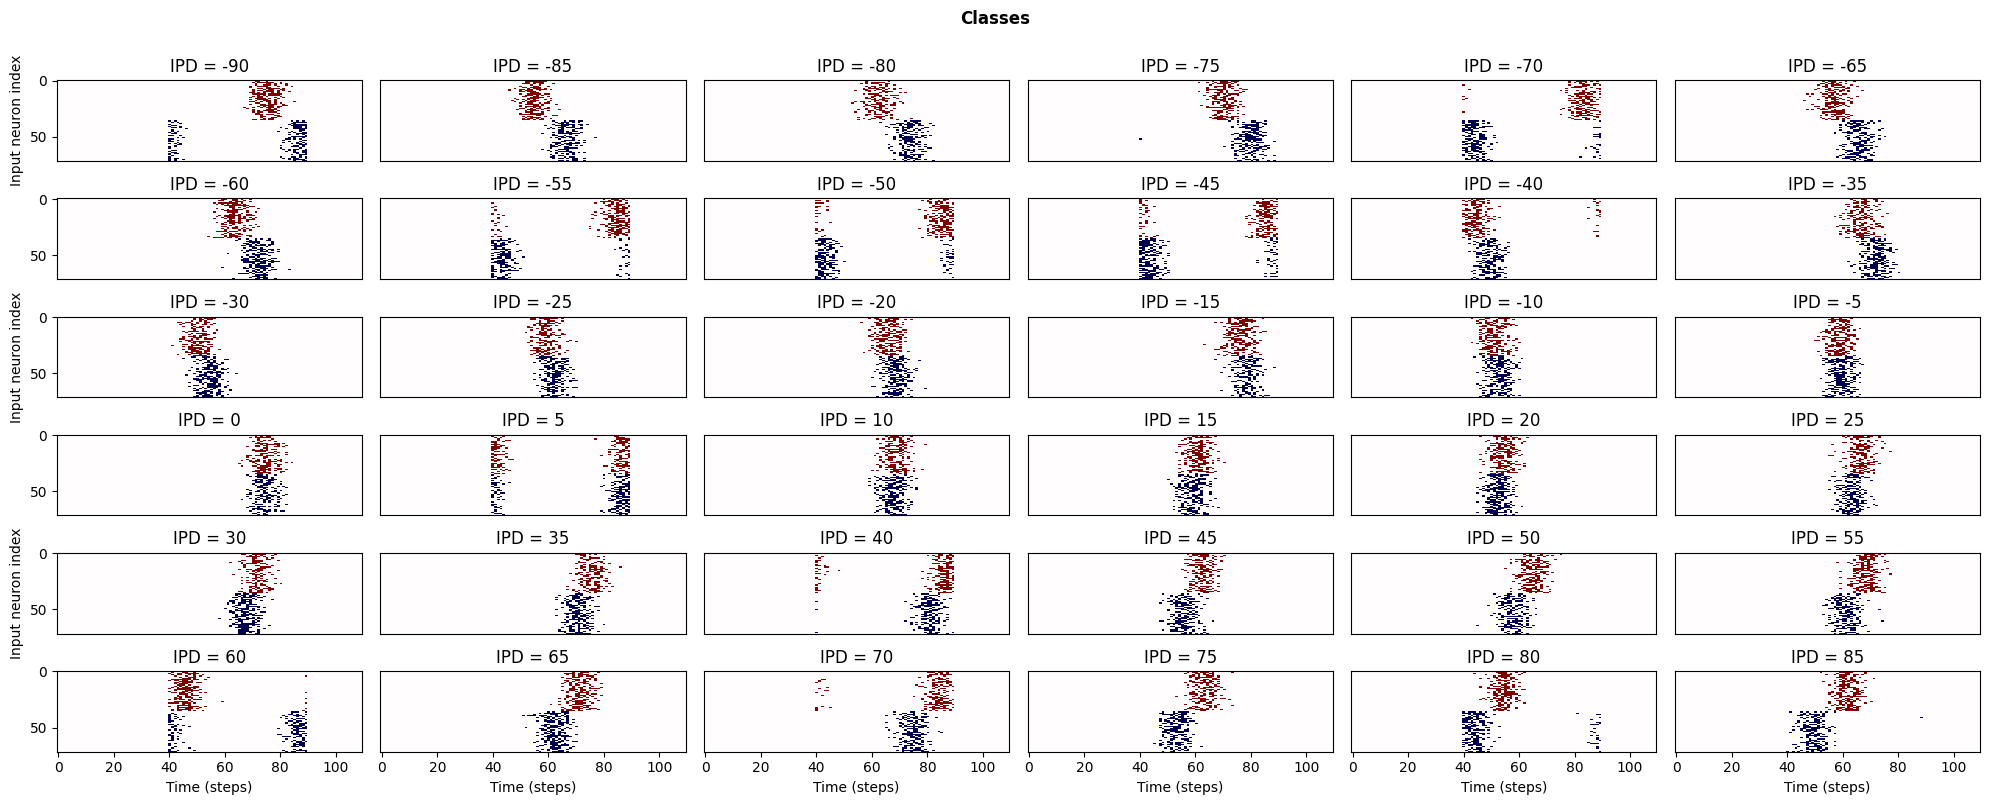

In [5]:
#@title Batch generator function and visualization of inputs
def get_batch():
    """Generates a batch of input-target pairs with a predefined length

    Parameters:

    Returns:
        inputs(torch.Tensor, (BATCH_SIZE, NUMBER_CLASSES, NUMBER_INPUTS, EFFECTIVE_DURATION)): A batch of input spike trains
        targets(torch.Tensor, (BATCH_SIZE, NUMBER_CLASSES)): A batch of one hot incoded targets
    """
    inputs, targets = [], []
    for _ in range(BATCH_SIZE):
        choice = np.random.choice(np.arange(-90, 90, ANG_STEP))
        value_input, value_target = next(input_signal(ipd_choice=choice))
        inputs.append(value_input)
        targets.append(value_target)
    yield torch.Tensor(np.array(inputs)), torch.Tensor(np.array(targets))

# The below code is for the visualization of the input spike trains
spikes_out_all, ipds_hot_all = [], []
for i in np.arange(-90, 90, ANG_STEP):
    spikes_out_temp, ipds_hot_temp= next(input_signal(ipd_choice=i))
    spikes_out_all.append(spikes_out_temp)
    ipds_hot_all.append(ipds_hot_temp)
spikes_out_all, ipds_hot_all = np.array(spikes_out_all), np.array(ipds_hot_all)
fig, axs = plt.subplots(6, 6, figsize=(20, 8), dpi=100)
ipds_range = np.arange(-90, 90, ANG_STEP)
for i, ax in enumerate(axs.flat):
    if SHOW_IMAGE:
        image_1 = spikes_out_all[i, 0, :, :].copy()
        image_1[image_1==0] = 0.75
        image_2 = spikes_out_all[i, 1, :, :].copy()*0.5
        image_2[image_2==0] = 0.75
        ax.imshow(np.concatenate((image_1, image_2)), aspect='auto',
                  interpolation='nearest', cmap='seismic')
    else:
        ax.imshow(spikes_out_all[i, :, i, :], aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
    ax.set_title(f'IPD = {ipds_range[i]}')
    if i >= 30:
        ax.set(xlabel='Time (steps)')
    if i % 12 == 0:
        ax.set(ylabel='Input neuron index')
    if i % 6 != 0:
        ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    if i < 30:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
fig.suptitle('Classes', fontweight="bold", x=0.5, y=1.0)
plt.tight_layout()
plt.show()

## Delay Layer

In [6]:
#@title Delay layer
np.random.seed(0)
torch.manual_seed(0)

class DelayLayer(nn.Module):
    """The delay layer class

    This class defines an array of differentiable delays of size (NUMBER_INPUTS, NUMBER_CLASSES) 
    to applied between any SNN layers

    Attributes:
        self.max_delay(int): maximum value of the applied delays
        self.trainable_delays(boolen): A flag that defines whether the delay array is differentiable or not
        self.number_inputs(int): the number of the input spike trains
        self.constant_delays(boolen): the initialized delays all have a constant value
        self.constant_value(int): the initialized delays constant value
        self.lr_delay(float): learning rate for the differentiable delays
        self.effective_duration(int): length of the agumented input duration in ms
        self.delays_out(int, (NUMBER_INPUTS, NUMBER_CLASSES)): the initialized delay array
        self.optimizer_delay(torch.optim): the backprop optimizer for the differentiable delays
    """

    def __init__(self, max_delay_in=19, train_delays=True, num_ear=2,
                 constant_delays=False, constant_value=0, lr_delay=1e-3):
        super().__init__()

        self.max_delay = max_delay_in
        self.trainable_delays = train_delays
        self.number_inputs = NUMBER_INPUTS
        self.constant_delays = constant_delays
        self.constant_value = constant_value
        self.lr_delay = lr_delay  # Not fine-tuned much
        self.effective_duration = EFFECTIVE_DURATION
        self.delays_out = self._init_delay_vector()
        self.optimizer_delay = self._init_optimizer()

    # Delays with constant or random initialisation
    # Might think of other ways to initialize delays and their effect on performance
    def _init_delay_vector(self):
        """the applied delays initializer

        Parameters:

        Returns:
            delays(int, (NUMBER_INPUTS, NUMBER_CLASSES)): the initialized delay array
        """
        if FIX_FIRST_INPUT:
            self.number_inputs = NUMBER_INPUTS - 1
        else:
            self.number_inputs = NUMBER_INPUTS
        if self.constant_delays:
            delays = torch.nn.parameter.Parameter(torch.FloatTensor(
                self.constant_value * np.ones((self.number_inputs, NUMBER_CLASSES), dtype=int)), requires_grad=self.trainable_delays)
        else:
            delays_numpy = np.random.randint(1, self.max_delay,
                                             size=(self.number_inputs, NUMBER_CLASSES), dtype=int)
            # delays_numpy = np.arange(0, 20, 1)
            delays = torch.nn.parameter.Parameter(torch.FloatTensor(delays_numpy), requires_grad=self.trainable_delays)

        return delays

    def _init_optimizer(self):
        """the delay optimizer initializer

        Parameters:

        Returns:
        """
        optimizer_delay = torch.optim.SGD([self.delays_out], lr=self.lr_delay)
        return optimizer_delay

    def forward(self, spikes_in):
        """forward pass through the delay layer

        Parameters:
            spikes_in(torch.Tensor, (BATCH_SIZE, NUMBER_INPUTS, NUMBER_CLASSES, EFFECTIVE_DURATION)): the input spike trains to be shifted

        Returns:
            output_train(torch.Tensor, (BATCH_SIZE, NUMBER_INPUTS, NUMBER_CLASSES, EFFECTIVE_DURATION)): the shifted(delay applied) spike trains
        """
        input_train = spikes_in[:, :, :, :, None]
        if FIX_FIRST_INPUT:
            input_first = input_train[:, 0:1, :, :, :]
            input_train = input_train[:, 1:, :, :, :]
        dlys = delay_fn(self.delays_out)
        batch_size, inputs, classes, duration, _ = input_train.size()
        # initialize M to identity transform and resize
        translate_mat = np.array([[1., 0., 0.], [0., 1., 0.]])
        translate_mat = torch.FloatTensor(np.resize(translate_mat, (batch_size, inputs, classes, 2, 3)))
        # translate with delays
        translate_mat[:, :, :, 0, 2] = 2 / (duration - 1) * dlys
        # create normalized 1D grid and resize
        x_t = np.linspace(-1, 1, duration)
        y_t = np.zeros((1, duration))  # 1D: all y points are zeros
        ones = np.ones(np.prod(x_t.shape))
        grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])   # an array of points (x, y, 1) shape (3, :)
        grid = torch.FloatTensor(np.resize(grid, (batch_size, inputs, classes, 3, duration)))
        # transform the sampling grid i.e. batch multiply
        translate_grid = torch.matmul(translate_mat, grid)
        # reshape to (num_batch, height, width, 2)
        translate_grid = torch.transpose(translate_grid, 3, 4)
        x_points = translate_grid[:, :, :, :, 0]
        corr_center = ((x_points + 1.) * (duration - 1)) * 0.5
        # grab 4 nearest corner points for each (x_t, y_t)
        corr_left = torch.floor(torch.round(corr_center, decimals=ROUND_DECIMALS)).type(torch.int64)
        corr_right = corr_left + 1
        # Calculate weights
        weight_right = (corr_right - corr_center)
        weight_left = (corr_center - corr_left)

        # Padding for values that are evaluated outside the input range
        pad_right = torch.amax(corr_right) + 1 - duration
        pad_left = torch.abs(torch.amin(corr_left))
        zeros_right = torch.zeros(size=(batch_size, inputs, classes, pad_right, 1))
        zeros_left = torch.zeros(size=(batch_size, inputs, classes, pad_left, 1))
        input_train = torch.cat((input_train, zeros_right), dim=3)
        # Get the new values after the transformation
        value_left = input_train[np.arange(batch_size)[:, None, None, None], np.arange(inputs)[None, :, None, None],
                                 np.arange(classes)[None, None, :, None], corr_left][:, :, :, :, 0]
        value_right = input_train[np.arange(batch_size)[:, None, None, None], np.arange(inputs)[None, :, None, None],
                                  np.arange(classes)[None, None, :, None], corr_right][:, :, :, :, 0]
        # compute output
        output_train = weight_right*value_left + weight_left*value_right
        if FIX_FIRST_INPUT:
            output_train = torch.concatenate((input_first[:, :, :, :, 0], output_train), dim=1)
        return output_train

## Surrogate Delays update

In [7]:
#@title Surrogate Delays
np.random.seed(0)
torch.manual_seed(0)

class DelayUpdate(torch.autograd.Function):
    """The delay update rounder and clamper class

    This class defines an object through which we can guarantee that the applied delays are whole numbers
    with in a specified range

    Attributes:
    """
    @staticmethod
    def forward(ctx, delays):
        """the forward pass through this class

        Parameters:

        Returns:
            delays_forward(int, (NUMBER_INPUTS, NUMBER_CLASSES)): the applied delays to the spike trains after rounding and clamping
        """
        delays_forward = torch.round(torch.clamp(delays, min=-delay_layer.max_delay, max=delay_layer.max_delay))
        return delays_forward

    @staticmethod
    def backward(ctx, grad_output):
        """the backprop pass through this class

        Parameters:

        Returns:
            delays_in(float, (NUMBER_INPUTS, NUMBER_CLASSES)): the acquired delays after the gradient update
        """
        delays_in = grad_output
        return delays_in

## Synaptic Integration function

In [8]:
#@title Synaptic integration function
# np.random.seed(0)
# torch.manual_seed(0)

def snn_sl(input_spikes):
    """Nonlinear integration of the spike trains to produce a target voltage (soma potential)

    Parameters:

    Returns:
        v_out(torch.Tensor, (BATCH_SIZE, NUMBER_CLASSES)): the result of the nonlinear integration 
    """
    input_spikes = delay_layer(input_spikes)
    duration_in = delay_layer.effective_duration
    """"""
    v = torch.zeros((BATCH_SIZE, NUMBER_INPUTS, NUMBER_CLASSES, delay_layer.effective_duration), dtype=dtype)
    alpha = np.exp(-1 / TAU)  # self-decay multiplier
    for t in range(duration_in - 1):  # Simple synaptic kernel application
        v[:, :, :, t] = alpha * v[:, :, :, t-1] + input_spikes[:, :, :, t]
    first_mat = v[:, 1:, :, :]
    if SYNAPSE_TYPE == 0:  # Multiplicative synapse
        v_mul = torch.mul(first_mat, v[:, 0:1, :, :])
        v_out = v_mul
    else:  # Subtractive synapse
        v_sub = -torch.square(torch.sub(first_mat, v[:, 0:1, :, :]))
        v_out = v_sub
    v_out = torch.sum(v_out, dim=1)
    v_out = torch.sum(v_out, dim=2)
    return v_out

## Training loop

Epoch 1: loss=213.89221
Tau:  39.800499167707294
Actual delays clamped:  tensor([13., 16.,  3.,  5.,  5.,  8., 10., 19.,  5.,  7., 12.,  4.,  7.,  7., 15., 17.,  6., 13.,  8., 10., 16.,  6., 16., 16.,  1., 19.,  4., 18., 14.,  8.,  0.,  1., 10.,  0., 11.,  3.],
       grad_fn=<RoundBackward0>) 





Epoch 2: loss=206.98854
Tau:  39.601993349966726
Actual delays clamped:  tensor([13., 16.,  4.,  5.,  6.,  8.,  9., 18.,  6.,  7., 10.,  4.,  6.,  6., 14., 17.,  5., 13.,  6.,  9., 15.,  5., 15., 15.,  2., 18.,  3., 18., 14.,  7.,  0.,  1., 10.,  1., 10.,  3.],
       grad_fn=<RoundBackward0>) 





Epoch 3: loss=221.05182
Tau:  39.40447758412251
Actual delays clamped:  tensor([13., 15.,  5.,  7.,  7.,  9.,  9., 18.,  6.,  7., 10.,  4.,  5.,  6., 14., 16.,  5., 12.,  5.,  9., 14.,  4., 15., 14.,  1., 18.,  2., 18., 13.,  6., -0.,  1.,  9.,  1., 10.,  3.],
       grad_fn=<RoundBackward0>) 





Epoch 4: loss=214.21939
Tau:  39.20794693227022
Actual delays clamped:  tensor([13., 15.,  6.,  7.

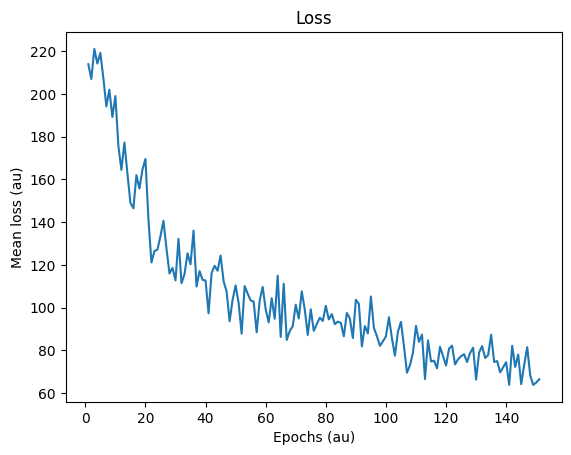







tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


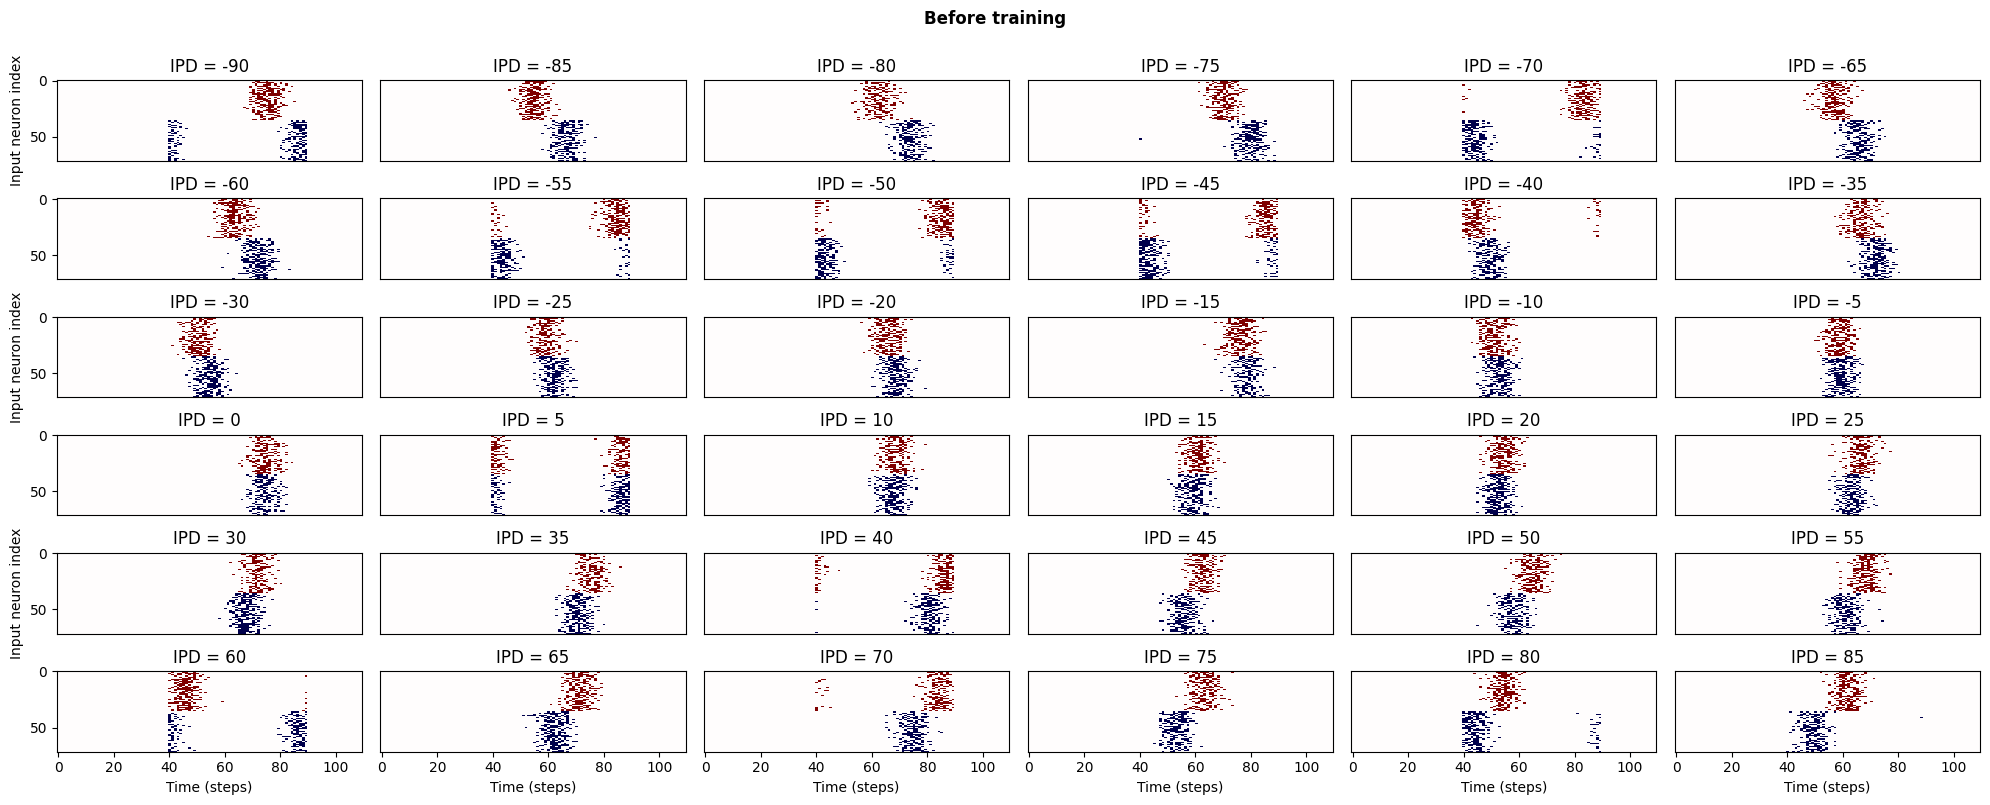

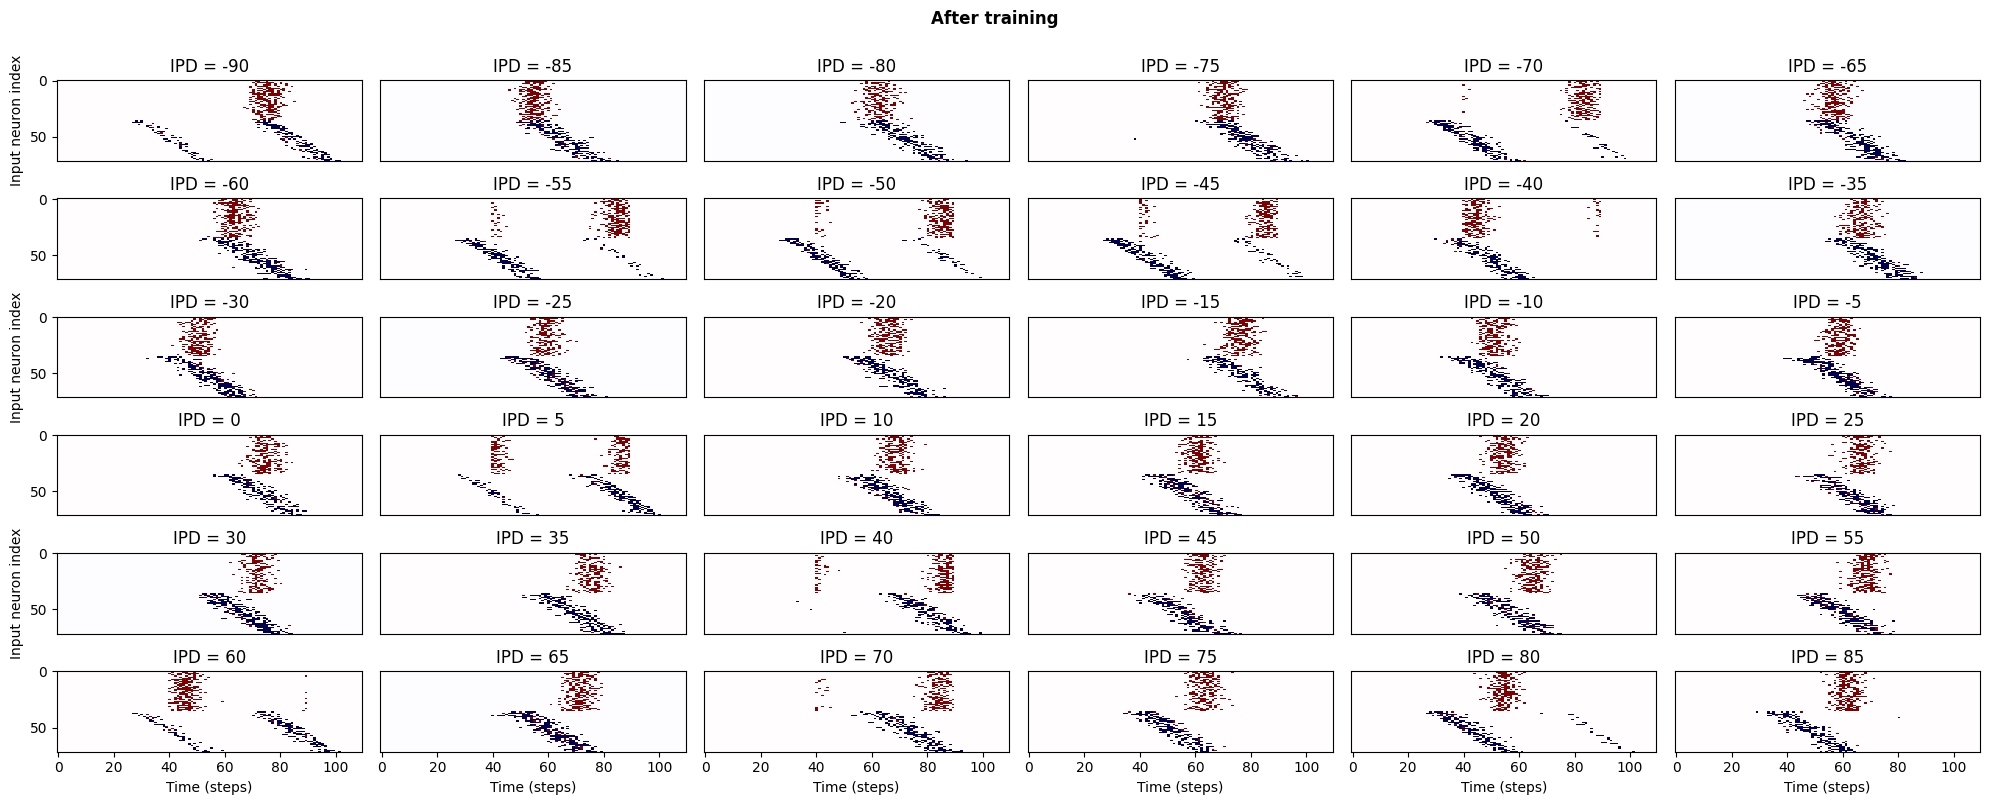

In [9]:
#@title Training loop and parameters
# np.random.seed(0)
# torch.manual_seed(0)
# torch.autograd.set_detect_anomaly(True)
delay_layer = DelayLayer(lr_delay=LR_DELAY, constant_delays=False, constant_value=0, max_delay_in=MAX_DELAY)  # A delay layer object
delay_fn = DelayUpdate.apply # An object that medisate the application of surrogate updates to the differentiable delays
optimizer_delay_apply = delay_layer.optimizer_delay 
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()
softmax_fn = nn.Softmax(dim=1)
loss_hist = []
X_TRAIN = []
Y_TRAIN = []
for e in range(NB_EPOCHS):
    local_loss = []
    for x_local, y_local in get_batch():
        X_TRAIN.append(x_local)
        output = snn_sl(x_local)  # Apply the synaptic integration with delays
        target = []
        for i in range(BATCH_SIZE):  # Convert the one hot incoded targets to whole numbers for the cross-entropy function
            target.append(np.where(y_local[i] > 0.5))
        target = torch.FloatTensor(np.array(target)).squeeze().to(torch.int64)
        Y_TRAIN.append(target)

        # If use weighting, increase the batch size as sometimes a class is not sampled
        # loss_w = torch.tensor(1 - (np.unique(target, return_counts=True)[1] / len(target))).float()
        # loss_fn = nn.NLLLoss(weight = loss_w/loss_w.sum())

        out_prop = log_softmax_fn(output)  # Apply log-softmax 
        loss = loss_fn(out_prop, target)  # Apply the cross-entropy loss
        local_loss.append(loss.item())
        optimizer_delay_apply.zero_grad()
        loss.backward()
        optimizer_delay_apply.step()
        """"""

    if TAU_DECAY_FLAG:  # Apply the tau decay operation
        if TAU >= TAU_MINI:
            TAU *= np.exp(-TAU_DECAY)
        else:
          TAU = TAU_MINI
        # print('Tau:', TAU)
    loss_hist.append(np.mean(local_loss))
    print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))
    print('Tau: ', TAU)
    print('Actual delays clamped: ', torch.round(torch.clamp(delay_layer.delays_out.flatten(),
                                                 min=-delay_layer.max_delay, max=delay_layer.max_delay)), '\n\n\n\n\n')
    
    if e >= 150:  # Visualization of the spike trains before and after the training
    # if np.mean(local_loss) < 3.6:
        plt.plot(np.arange(1, e+2, 1), loss_hist)
        plt.title('Loss')
        plt.xlabel('Epochs (au)')
        plt.ylabel('Mean loss (au)')
        plt.show()
        print('\n\n\n\n\n')

        trial_input_all = spikes_out_all.copy()
        trial_input = torch.FloatTensor(trial_input_all.copy())
        trial_out = delay_layer.forward(trial_input).detach()
        fig_1, axs_1 = plt.subplots(6, 6, figsize=(20, 8), dpi=100)
        for i, ax in enumerate(axs_1.flat):
            if SHOW_IMAGE:
                image_1 = trial_input[i, 0, :, :].clone()
                image_1[image_1==0] = 0.75
                image_2 = trial_input[i, 1, :, :].clone()*0.5
                image_2[image_2==0] = 0.75
                ax.imshow(np.concatenate((image_1, image_2)), aspect='auto',
                  interpolation='nearest', cmap='seismic')
            else:
                ax.imshow(trial_input[i, :, i, :], aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
            ax.set_title(f'IPD = {ipds_range[i]}')
            if i >= 30:
                ax.set(xlabel='Time (steps)')
            if i % 12 == 0:
                ax.set(ylabel='Input neuron index')
            if i % 6 != 0:
                ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
            if i < 30:
                ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        fig_1.suptitle('Before training', fontweight="bold", x=0.5, y=1.0)
        plt.tight_layout()
        fig_2, axs_2 = plt.subplots(6, 6, figsize=(20, 8), dpi=100)
        print(trial_input[0, 0, 0, :],trial_out[0, 0, 0, :])
        for i, ax in enumerate(axs_2.flat):
            if SHOW_IMAGE:
                image_1 = trial_out[i, 0, :, :].clone()
                image_1[image_1==0] = 0.5
                image_2 = trial_out[i, 1, :, :].clone()
                image_2[image_2==0] = 0.5
                image_2[image_2==1] = 0.0
                ax.imshow(np.concatenate((image_1, image_2)), aspect='auto',
                interpolation='nearest', cmap='seismic')
            else:
                ax.imshow(trial_out[i, :, i, :], aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
            ax.set_title(f'IPD = {ipds_range[i]}')
            if i >= 30:
                ax.set(xlabel='Time (steps)')
            if i % 12 == 0:
                ax.set(ylabel='Input neuron index')
            if i % 6 != 0:
                ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
            if i < 30:
                ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        fig_2.suptitle('After training', fontweight="bold", x=0.5, y=1.0)
        plt.tight_layout()
        plt.show()
        break

## Performance measure one

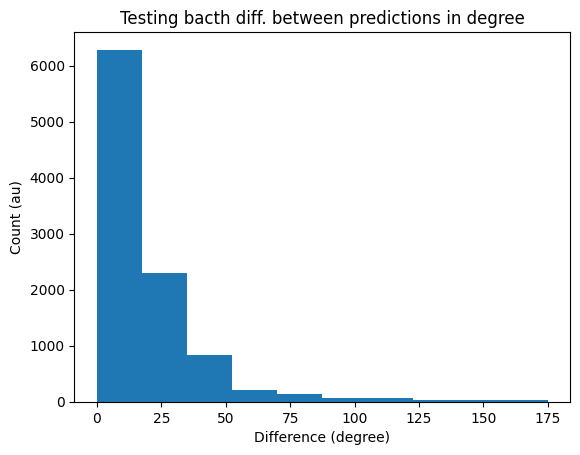

In [10]:
#@title Test performance
trial_count = 50
test_array = []
np.random.seed(0)
torch.manual_seed(0)

for _ in range(trial_count):  # An algorithm to compute the difference between the prediction and target in degrees
    x_test, y_test = next(get_batch())
    output = snn_sl(x_test)
    max_index = torch.argmax(output, dim=1).detach().numpy()
    target = []
    for i in range(BATCH_SIZE):
        target.append(np.where(y_test[i] > 0.5))
    target = torch.FloatTensor(np.array(target)).squeeze().to(torch.int64)
    diff_pred = torch.abs(target-max_index)
    test_array.extend(list(diff_pred.detach().numpy()))
diff_pred = np.array(test_array)

plt.hist(diff_pred*ANG_STEP)
plt.title('Testing bacth diff. between predictions in degree')
plt.xlabel('Difference (degree)')
plt.ylabel('Count (au)')
plt.show()

## Performance measure two

Chance accuracy level: 2.8%

Train classifier accuracy: 10.9%
Train absolute error: 19.5 deg

Test classifier accuracy: 11.8%
Test absolute error: 19.1 deg


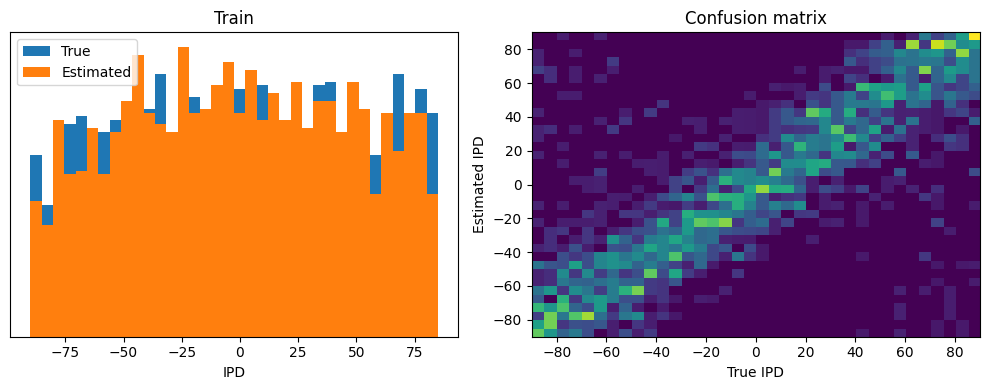

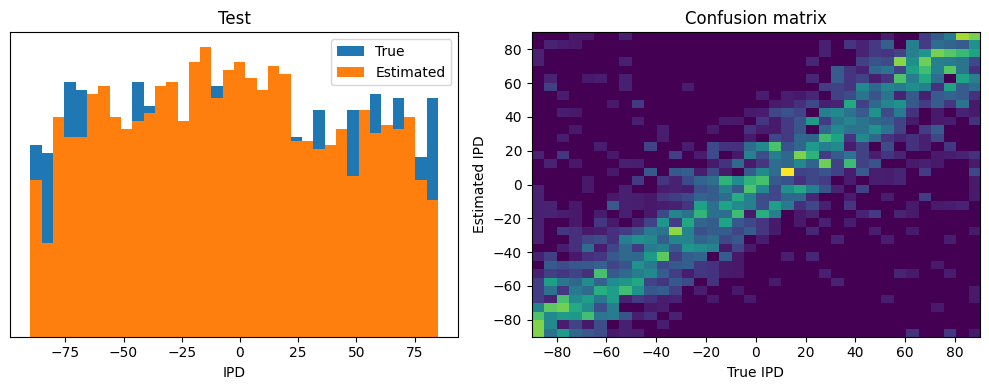

In [11]:
#@title Analyse (taken from the starting notebook)
def chunker(seq, size):  # A function to iterate over a list/array in fixed sizes
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

XS_TRAIN = torch.FloatTensor(np.concatenate(X_TRAIN, axis=0 ))
YS_TRAIN = np.concatenate(Y_TRAIN, axis=0 )
BATCH_SIZE, increments = XS_TRAIN.shape[0], 2000
BATCH_SIZE = increments
YS_TEST = []
XS_TEST, Y_TEST = next(get_batch())
for i in range(BATCH_SIZE):
    YS_TEST.append(np.where(Y_TEST[i] > 0.5))
YS_TEST = np.array(YS_TEST).squeeze()

def analyse(label, ipds=0, spikes=0, run=0):
    """Visualization of the results of training

    Parameters:
        label(string): Type of inputs (train or test)
        ipds(numpy.ndarray, (BATCH_SIZE, NUMBER_CLASSES)): A batch of targets in whole number form
        spikes(torch.Tensor, (BATCH_SIZE, NUMBER_CLASSES, NUMBER_INPUTS, EFFECTIVE_DURATION)): A batch of input spike trains
        run: A callable function

    Returns:
    """
    spikes = spikes[:increments, :, :, :]
    ipds = ipds[:increments]
    confusion = np.zeros((NUMBER_CLASSES, NUMBER_CLASSES))
    output = []
    ipds_range = np.arange(-90, 90, ANG_STEP)
    ipds_true_deg = []
    ipds_est_deg = []
    for i in chunker(spikes, increments):  # Chunk an array into fixed sizes
        output_temp = run(i)
        output.append(output_temp.detach().cpu().numpy())

    output = torch.FloatTensor(np.concatenate(output, axis=0 ))
    ipds_true = torch.FloatTensor(ipds)
    _, ipds_est = torch.max(output, 1)  # argmax over output units
    tmp = np.mean((ipds_true == ipds_est).detach().cpu().numpy())  # compare to labels
    ipds_true = ipds_true.detach().cpu().numpy()
    ipds_est = ipds_est.detach().cpu().numpy()
    for i, j in zip(ipds_true, ipds_est):  # Generate the confusion matrix
        confusion[int(j), int(i)] += 1
        ipds_true_deg.append(ipds_range[int(i)])
        ipds_est_deg.append(ipds_range[int(j)])
    ipds_true_deg = np.array(ipds_true_deg)
    ipds_est_deg = np.array(ipds_est_deg)
    abs_errors_deg = abs(ipds_true_deg-ipds_est_deg)
    print()
    print(f"{label} classifier accuracy: {100*np.mean(tmp):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(121)
    plt.hist(ipds_true_deg, bins=NUMBER_CLASSES, label='True')
    plt.hist(ipds_est_deg, bins=NUMBER_CLASSES, label='Estimated')
    plt.xlabel("IPD")
    plt.yticks([])
    plt.legend(loc='best')
    plt.title(label)
    plt.subplot(122)
    confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
    plt.imshow(confusion, interpolation='nearest', aspect='auto', origin='lower', extent=(-90, 90, -90, 90))
    plt.xlabel('True IPD')
    plt.ylabel('Estimated IPD')
    plt.title('Confusion matrix')
    plt.tight_layout()    

print(f"Chance accuracy level: {100*1/NUMBER_CLASSES:.1f}%")
run_func = lambda x: snn_sl(x)
analyse('Train', ipds=YS_TRAIN, spikes=XS_TRAIN, run=run_func)
analyse('Test', ipds=YS_TEST, spikes=XS_TEST, run=run_func)